In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm  # Import the normal distribution from SciPy
from scipy.stats import multivariate_normal # Import the multivariate normal distribution from SciPy
import tensorflow as tf


# Let's implement the Metropolis Hastings algorithm

## 1. Dimension = 1

In [ ]:
def metropolis_hastings(target_distribution, proposal_distribution, initial_state, iterations):
    samples = [initial_state]

    for _ in range(iterations):
        current_state = samples[-1]

        # Generate a candidate sample from the proposal distribution
        candidate_state = proposal_distribution(current_state)

        # Calculate the acceptance probability
        acceptance_ratio = min(1, (target_distribution(candidate_state) * proposal_distribution(current_state)) /
                                       (target_distribution(current_state) * proposal_distribution(candidate_state)))

        # Accept or reject the candidate
        if np.random.rand() < acceptance_ratio:
            samples.append(candidate_state)
        else:
            samples.append(current_state)

    return samples

# Example usage:
# Define target and proposal distributions as functions
target_distribution = lambda x: np.exp(-x**2)  # Example: normal distribution
proposal_distribution = lambda x: np.random.uniform(x-0.5,x+0.5) # Example: uniform distribution



# Initial state and number of iterations
initial_state = 0
iterations = 100000

# Run Metropolis-Hastings algorithm
samples = metropolis_hastings(target_distribution, proposal_distribution, initial_state, iterations)



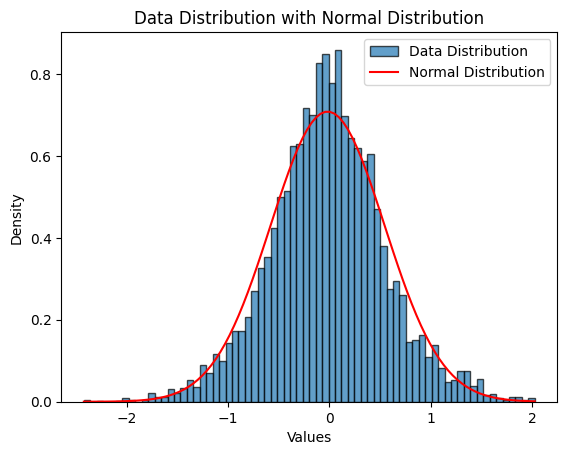

In [ ]:
# Keeping only the last 10 percents of the sample

data = samples[int(iterations*(9/10)):]

# Plotting the histogram of data
plt.hist(data, bins='auto', density=True, alpha=0.7, edgecolor='black', label='Data Distribution')

# Calculate the mean and standard deviation of the data
mean_data = np.mean(data)
std_data = np.std(data)

# Generate values for the x-axis based on the normal distribution
x = np.linspace(min(data), max(data), 100)
# Compute the PDF of the normal distribution using mean and standard deviation
y = norm.pdf(x, mean_data, std_data)

# Plotting the normal distribution
plt.plot(x, y, label='Normal Distribution', color='red')

# Set labels and title
plt.title('Data Distribution with Normal Distribution')
plt.xlabel('Values')
plt.ylabel('Density')

# Display legend
plt.legend()

# Show the plot
plt.show()

## 2. Dimension = n

In [ ]:

def metropolis_hastings_multivariate(target_distribution, proposal_distribution, initial_state, iterations):
    dimension = len(initial_state)
    samples = [initial_state]

    for _ in range(iterations):
        current_state = np.array(samples[-1])

        # Generate a candidate sample from the multivariate proposal distribution
        candidate_state = proposal_distribution(current_state)

        # Calculate the acceptance probability
        acceptance_ratio = min(1, target_distribution(candidate_state) / target_distribution(current_state))

        # Accept or reject the candidate
        if np.random.rand() < acceptance_ratio:
            samples.append(candidate_state)
        else:
            samples.append(current_state)

    return np.array(samples)

# Example of a multivariate normal distribution as the target
mean = np.array([0, 0])
covariance = np.array([[1, 0.5], [0.5, 1]])
target_distribution = multivariate_normal(mean=mean, cov=covariance).pdf

# Example of a multivariate normal distribution as the proposal
proposal_distribution = lambda x: np.random.multivariate_normal(x, np.eye(len(x)))

# Initial state and number of iterations
initial_state = np.array([0, 0])
iterations = 100000

# Run Metropolis-Hastings algorithm
samples = metropolis_hastings_multivariate(target_distribution, proposal_distribution, initial_state, iterations)


# Let's apply the ERM-RER method to image classification on the MNIST dataset


## Benchmark, small ERM neural network

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Load the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test.reshape(-1, 1, 784) / 255.0
x_train = x_train.reshape(-1, 1, 784) / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Define the neural network architecture
class CustomModel(tf.keras.Model):
    def __init__(self, weights, biases):
        super(CustomModel, self).__init__()
        self.weights1 = tf.Variable(weights[0], trainable=False)
        self.biases1 = tf.Variable(biases[0], trainable=False)
        self.weights2 = tf.Variable(weights[1], trainable=False)
        self.biases2 = tf.Variable(biases[1], trainable=False)
        self.weights3 = tf.Variable(weights[2])
        self.biases3 = tf.Variable(biases[2])

    def call(self, inputs):
        x = tf.nn.relu(tf.matmul(inputs, self.weights1) + self.biases1)
        x = tf.nn.relu(tf.matmul(x, self.weights2) + self.biases2)
        return tf.nn.softmax(tf.matmul(x, self.weights3) + self.biases3)

# Define the weights and biases
weights = [
    np.random.randn(784, 5),  # Input to first hidden layer
    np.random.randn(5, 5),    # First hidden layer to second hidden layer
    np.random.randn(5, 10)    # Second hidden layer to output layer
]
biases = [
    np.random.randn(5),  # Biases for first hidden layer
    np.random.randn(5),  # Biases for second hidden layer
    np.random.randn(10)  # Biases for output layer
]


## Let's apply Metropolis Hastings algorithm to compute the expected model from the ERM-RER problem

In [ ]:
# Define the empirical risk
def empirical_risk( weights, biases, x, y):

  # Create an instance of the model
  custom_model = CustomModel(weights, biases)

  # Compute the cross-entropy loss for the single image
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  loss = loss_fn(y, custom_model.call(x))

  return loss

### Metropolis Hastings using the cross entropy loss

In [ ]:
# Proposal distribution function
def proposal_distribution(weights, biases):
    proposed_weights = [
    np.random.normal(weights[0], scale=1),  # Input to first hidden layer
    np.random.normal(weights[1], scale=1),    # First hidden layer to second hidden layer
    np.random.normal(weights[2], scale=1)    # Second hidden layer to output layer
    ]
    proposed_biases = [
        np.random.normal(biases[0], scale=1),  # Biases for first hidden layer
        np.random.normal(biases[1], scale=1),  # Biases for second hidden layer
        np.random.normal(biases[2], scale=1)  # Biases for output layer
    ]
    return proposed_weights, proposed_biases

# Metropolis-Hastings algorithm
def metropolis_hastings( x, y, num_samples, burn_in, Lambda):
    current_weights = [
    np.random.randn(784, 5),  # Input to first hidden layer
    np.random.randn(5, 5),    # First hidden layer to second hidden layer
    np.random.randn(5, 10)]    # Second hidden layer to output layer

    current_biases = [
        np.random.randn(5),  # Biases for first hidden layer
        np.random.randn(5),  # Biases for second hidden layer
        np.random.randn(10)]  # Biases for output layer

    current_cross_entropy = empirical_risk(current_weights, current_biases, x, y)
    samples = []

    for _ in range(num_samples + burn_in):

        proposed_weights, proposed_biases = proposal_distribution(current_weights, current_biases)
        proposed_cross_entropy = empirical_risk(proposed_weights, proposed_biases, x, y)

        acceptance_ratio = min(1, np.exp(-(proposed_cross_entropy - current_cross_entropy)/Lambda))

        if np.random.rand() < acceptance_ratio:
            current_weights, current_biases = proposed_weights, proposed_biases
            current_cross_entropy = proposed_cross_entropy
        if _ >= burn_in:
            samples.append((current_weights, current_biases))

    return samples



In [ ]:
# Example usage
num_samples = 1000
burn_in = 0
Lambda = 0.1
samples = metropolis_hastings(x_train, y_train, num_samples, burn_in, Lambda)

In [ ]:
# Compute the mean of the samples
def compute_mean(samples):
    total_weights_0 = np.zeros_like(samples[0][0][0])
    total_weights_1 = np.zeros_like(samples[0][0][1])
    total_weights_2 = np.zeros_like(samples[0][0][2])
    total_biases_0 = np.zeros_like(samples[0][1][0])
    total_biases_1 = np.zeros_like(samples[0][1][1])
    total_biases_2 = np.zeros_like(samples[0][1][2])

    for weights, biases in samples:
        total_weights_0 += weights[0]
        total_weights_1 += weights[1]
        total_weights_2 += weights[2]

        total_biases_0 += biases[0]
        total_biases_1 += biases[1]
        total_biases_2 += biases[2]

    mean_weights_0 = total_weights_0 / len(samples)
    mean_weights_1 = total_weights_1 / len(samples)
    mean_weights_2 = total_weights_2 / len(samples)

    mean_biases_0 = total_biases_0 / len(samples)
    mean_biases_1 = total_biases_1 / len(samples)
    mean_biases_2 = total_biases_2 / len(samples)

    mean_weights = [ mean_weights_0, mean_weights_1, mean_weights_2]
    mean_biases = [ mean_biases_0, mean_biases_1, mean_biases_2]

    return mean_weights, mean_biases

# Compute the mean of the samples
mean_weights, mean_biases = compute_mean(samples)


In [ ]:
def get_predicted_classes(logit):

    # Find the index of the class with the highest probability
    predicted_class = np.argmax(logit)

    return predicted_class

# Create an instance of CustomModel
model = CustomModel(mean_weights, mean_biases)


# Pass the input data through the model
logits = [model.call(x_test[i]) for i in range(len(x_test))]

# Get the predicted classes
predicted_classes = [get_predicted_classes(logit.numpy()) for logit in logits]  # Convert logits to NumPy array and pass it to get_predicted_classes function

# Compute accuracy
accuracy = np.sum(predicted_classes == y_test) / len(y_test)
accuracy

0.098